In [1]:
import pandas as pd
import numpy as np
import itertools
import torch
import time, copy
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info

from main.layout import Layout
from main.algorithms import enum_layout_wo_rdt, init_S

In [33]:
!squeue -u lijunzhang

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8518430 titanx-lo      V31 lijunzha PD       0:00      1 (Resources)
           8518431 titanx-lo      V49 lijunzha PD       0:00      1 (Priority)
           8518432 titanx-lo      V38 lijunzha PD       0:00      1 (Priority)
           8518433 titanx-lo      V48 lijunzha PD       0:00      1 (Priority)
           8518434 titanx-lo      V40 lijunzha PD       0:00      1 (Priority)
           8518435 titanx-lo      V17 lijunzha PD       0:00      1 (Priority)
           8518436 titanx-lo       V4 lijunzha PD       0:00      1 (Priority)
           8518437 titanx-lo       V1 lijunzha PD       0:00      1 (Priority)
           8518438 titanx-lo      V27 lijunzha PD       0:00      1 (Priority)
           8518439 titanx-lo       V6 lijunzha PD       0:00      1 (Priority)
           8518440 titanx-lo      V23 lijunzha PD       0:00      1 (Priority)
           8518402 1080ti-lo      FO0 lijunzh

In [23]:
!ls /mnt/nfs/work1/huiguan/lijunzhang/multibranch/log/NYUv2/

2task_mobilenet_0116  2task_resnet34_noise  verify_0123		verify_1026
2task_mobilenet_0124  baseline		    verify_0123_reload	verify_1102
2task_mobilenet_0221  exp		    verify_0124		verify_1116
2task_mobilenet_1206  verify_0105	    verify_0221		verify_1118
2task_resnet34	      verify_0105_resnet    verify_1007		verify_1214
2task_resnet34_1019   verify_0111	    verify_1014
2task_resnet34_1129   verify_0116	    verify_1019


In [31]:
!scancel 8518428

# All Layouts

In [2]:
# Enum all layouts for given T (5 for Taskonomy) and B (17 for Deeplab_Resnet34)
start_time = time.time()

T = 5 # segment_semantic, normal, depth_zbuffer, keypoints2d, edge_texture
B = 5

layout_list = [] 
S0 = init_S(T, B) # initial state
L = Layout(T, B, S0) # initial layout
layout_list.append(L)

enum_layout_wo_rdt(L, layout_list)
print(len(layout_list))

print("--- %s seconds ---" % (time.time() - start_time))

7556
--- 66.10369229316711 seconds ---


# Learn to Branch Layout idx

In [ ]:
# learn to branch
S_b = copy.deepcopy(S0)
S_b[4] = [{0,1,2},{3,4}]
# S_b[15] = [{0,1,2},{3,4}]

# BMTAS
S_b[4] = [{0,2,4},{1,3}]

# AutoMTL
# S_b[0] = [{0,1,2},{3},{4}]
# S_b[1] = [{0,1,2},{3},{4}]
# S_b[2] = [{0,1,2},{3},{4}]
# S_b[3] = [{0},{1},{2},{3},{4}]
# S_b[4] = [{0},{1},{2},{3},{4}]

In [ ]:
# task grouping
S_b = copy.deepcopy(S0)
for i in range(B):
    S_b[i] = [{0},{1,2,3},{4}]

In [ ]:
layout_list.index(Layout(T, B, S_b))

In [64]:
S_b

[[{0, 1, 2, 3, 4}],
 [{0, 1, 2, 3, 4}],
 [{0, 1, 2, 3, 4}],
 [{0, 1, 2, 3, 4}],
 [{0, 2, 4}, {1, 3}]]

In [6]:
layout_list[1]

[[{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}]]

In [7]:
layout_list[353]

[[{1, 2, 3, 4}, {0}], [{0}, {3, 4}, {1, 2}], [{0}, {1, 2}, {4}, {3}], [{0}, {1, 2}, {4}, {3}], [{0}, {4}, {3}, {2}, {1}]]

# Paper

In [3]:
GMac = [93,
        82.288,84.028,72.318,71.598,72.318,
        72.318,71.598,72.318,53.878,66.578,
        53.878,53.878,55.548,48.138,54.818,
        37.108,37.108,36.988,36.268,37.108,
        18.558]
Delta_acc = [0.0,
             4.9,4.2,4.3,2.7,3.4
            ,4.3,2.7,3.4,2.9,4.1
            ,2.9,3.3,3.0,2.1,2.8
            ,2.3,1.1,1.3,0.6,-0.9
            ,-4.9]

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
c = ['#9467bd']
k = 5
for i in range(len(colors)):
    if i < 4:
        for repeat in range(k):
            c.append(colors[i])
    else:
        c.append(colors[i])

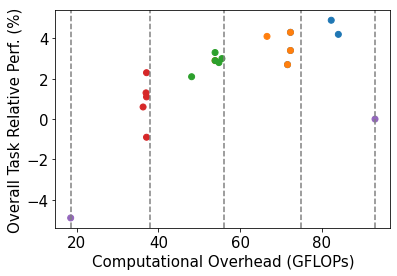

In [6]:
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(6,4))
plt.xlabel('Computational Overhead (GFLOPs)')
plt.ylabel('Overall Task Relative Perf. (%)')
# plt.xlim(right=92.778)
plt.scatter(GMac, Delta_acc, c=c)

plt.axvline(x=93, color='grey', linestyle='--')
plt.axvline(x=75, color='grey', linestyle='--')
plt.axvline(x=56, color='grey', linestyle='--')
plt.axvline(x=38, color='grey', linestyle='--')
plt.axvline(x=18.55, color='grey', linestyle='--')

plt.savefig('perf-overhead.png', bbox_inches='tight')